# K-Means Clustering for Fruit Classification

---
## 1. Import Libraries

In [ ]:
import os
import numpy as np
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from skimage import color

print("All libraries imported successfully!")

All libraries imported successfully!


---
## 2. Configuration

Set all hyperparameters and paths here.

In [ ]:
BASE_PATH = r"C:\Fruits5_MyProject\all_images"

CLASSES = ['Apple', 'Banana', 'Cucumber', 'Onion', 'Pear']
NUM_CLASSES = len(CLASSES)
IMG_SIZE = (100, 100)

N_CLUSTERS = 25
PCA_COMPONENTS = 200
TEST_SIZE = 0.2
RANDOM_STATE = 42

print(f"Dataset: {NUM_CLASSES} classes")
print(f"Image Size: {IMG_SIZE}")
print(f"K-Means Clusters: {N_CLUSTERS}")
print(f"PCA Components: {PCA_COMPONENTS}")

Dataset: 5 classes
Image Size: (100, 100)
K-Means Clusters: 25
PCA Components: 200


---
## 3. Feature Extraction Functions

We extract two types of features:
- **Color Histograms**: Capture color distribution (96 features)
- **HOG (Histogram of Oriented Gradients)**: Capture shape and texture (~1764 features)

In [4]:
def extract_color_histogram(image, bins=32):
    hist_r = np.histogram(image[:, :, 0], bins=bins, range=(0, 256))[0]
    hist_g = np.histogram(image[:, :, 1], bins=bins, range=(0, 256))[0]
    hist_b = np.histogram(image[:, :, 2], bins=bins, range=(0, 256))[0]
    hist = np.concatenate([hist_r, hist_g, hist_b])
    # Normalize
    hist = hist / (hist.sum() + 1e-7)
    return hist


def extract_hog_features(image):
    gray = color.rgb2gray(image)
    features = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=False,
        feature_vector=True
    )
    return features


def extract_features(image):
    color_hist = extract_color_histogram(image, bins=32)
    hog_feat = extract_hog_features(image)
    combined = np.concatenate([color_hist, hog_feat])
    return combined


print("Feature extraction functions defined!")

Feature extraction functions defined!


---
## 4. Data Loading

Load all images and extract features.

In [ ]:
def load_all_images(base_path, img_size=IMG_SIZE):
    X, y = [], []
    
    print("=" * 70)
    print("Loading and extracting features from images...")
    print("=" * 70)
    
    for idx, cls in enumerate(CLASSES):
        folder = os.path.join(base_path, cls)
        print(f"Loading {cls}...", end=" ")
        count = 0
        
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            img = Image.open(img_path).convert('RGB')
            img = img.resize(img_size)
            img_array = np.array(img)
            
            features = extract_features(img_array)
            X.append(features)
            y.append(idx)
            count += 1
        
        print(f"{count} images loaded")
    
    print("=" * 70)
    return np.array(X), np.array(y)


X, y = load_all_images(BASE_PATH, img_size=IMG_SIZE)

print(f"\n Dataset Summary:")
print(f"  Total images: {X.shape[0]}")
print(f"  Features per image: {X.shape[1]}")

Loading and extracting features from images...
Loading Apple... 2000 images loaded
Loading Banana... 2000 images loaded
Loading Cucumber... 2000 images loaded
Loading Onion... 2000 images loaded
Loading Pear... 2000 images loaded

 Dataset Summary:
  Total images: 10000
  Features per image: 4452


---
## 5. Data Preprocessing

Steps:
1. **Train-Test Split** (80/20)
2. **Feature Scaling** (StandardScaler)
3. **PCA** (Dimensionality Reduction)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

Training samples: 8000
Test samples: 2000


In [ ]:
print("\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features scaled!")


Scaling features...
Features scaled!


In [ ]:
print(f"\nApplying PCA (reducing to {PCA_COMPONENTS} components)...")
pca = PCA(n_components=PCA_COMPONENTS, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"  PCA applied!")
print(f"  Explained variance: {pca.explained_variance_ratio_.sum()*100:.2f}%")
print(f"  Final features: {X_train_pca.shape[1]}")


Applying PCA (reducing to 200 components)...


  PCA applied!
  Explained variance: 73.42%
  Final features: 200


---
## 6. K-Means Clustering

Train K-Means with optimized parameters.

In [ ]:
print(f"\nTraining K-Means with {N_CLUSTERS} clusters...")
kmeans = KMeans(
    n_clusters=N_CLUSTERS,
    init='k-means++',
    n_init=20,
    max_iter=500,
    random_state=RANDOM_STATE,
    verbose=0
)
kmeans.fit(X_train_pca)
print(" K-Means trained!")

y_pred_train = kmeans.predict(X_train_pca)
y_pred_test = kmeans.predict(X_test_pca)
print(f" Predictions generated!")


Training K-Means with 25 clusters...
 K-Means trained!
 Predictions generated!


---
## 7. Majority Voting & Evaluation

Map each cluster to the most common label (Majority Voting).

In [ ]:
print("\n" + "=" * 70)
print("Cluster to Label Mapping (Majority Voting):")
print("=" * 70)

mapping = {}
for cluster_id in range(N_CLUSTERS):
    samples_in_cluster = y_train[y_pred_train == cluster_id]
    
    if len(samples_in_cluster) > 0:
        most_common_label = Counter(samples_in_cluster).most_common(1)[0][0]
        mapping[cluster_id] = most_common_label
        count = len(samples_in_cluster)
        purity = (samples_in_cluster == most_common_label).sum() / count * 100
        print(f"  Cluster {cluster_id:2d} -> {CLASSES[most_common_label]:10s} "
              f"({count:4d} samples, {purity:5.1f}% purity)")
    else:
        mapping[cluster_id] = 0

print("=" * 70)


Cluster to Label Mapping (Majority Voting):
  Cluster  0 -> Onion      ( 403 samples,  50.4% purity)
  Cluster  1 -> Pear       ( 344 samples,  93.9% purity)
  Cluster  2 -> Cucumber   ( 422 samples,  50.9% purity)
  Cluster  3 -> Cucumber   ( 343 samples,  72.9% purity)
  Cluster  4 -> Apple      ( 388 samples,  94.8% purity)
  Cluster  5 -> Onion      ( 297 samples,  69.0% purity)
  Cluster  6 -> Onion      ( 882 samples,  47.3% purity)
  Cluster  7 -> Cucumber   ( 357 samples, 100.0% purity)
  Cluster  8 -> Pear       ( 352 samples,  50.6% purity)
  Cluster  9 -> Onion      ( 250 samples, 100.0% purity)
  Cluster 10 -> Pear       ( 327 samples,  70.9% purity)
  Cluster 11 -> Apple      ( 329 samples, 100.0% purity)
  Cluster 12 -> Banana     ( 223 samples,  80.7% purity)
  Cluster 13 -> Pear       ( 188 samples, 100.0% purity)
  Cluster 14 -> Pear       ( 133 samples, 100.0% purity)
  Cluster 15 -> Banana     ( 441 samples,  91.2% purity)
  Cluster 16 -> Banana     ( 160 samples,  

In [ ]:
y_pred_test_mapped = np.array([mapping[label] for label in y_pred_test])

accuracy = accuracy_score(y_test, y_pred_test_mapped)

print("\n" + "=" * 70)
print(f"FINAL TEST ACCURACY = {accuracy*100:.2f}%")
print("=" * 70)


FINAL TEST ACCURACY = 78.60%


---
## 8. Visualization

### 8.1 Confusion Matrix

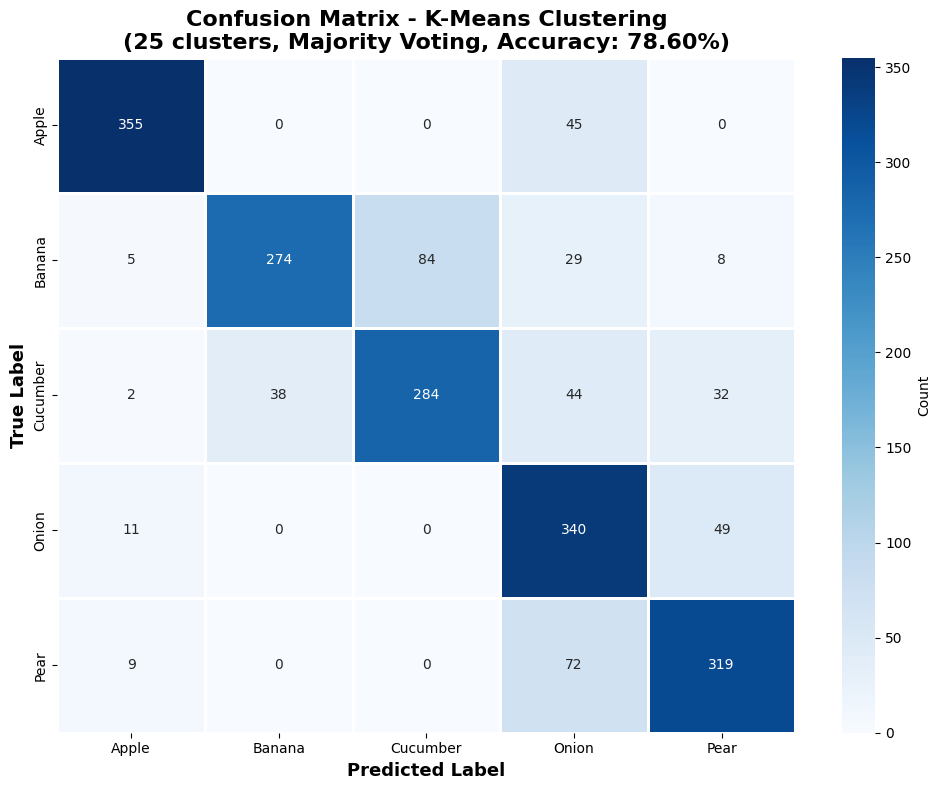

In [ ]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_test_mapped)
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    linewidths=2, linecolor='white',
    xticklabels=CLASSES, yticklabels=CLASSES,
    cbar_kws={'label': 'Count'}
)
plt.title(f'Confusion Matrix - K-Means Clustering\n'
          f'({N_CLUSTERS} clusters, Majority Voting, Accuracy: {accuracy*100:.2f}%)',
          fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

### 8.2 Elbow Method

Find the optimal number of clusters.

Calculating Elbow Method...


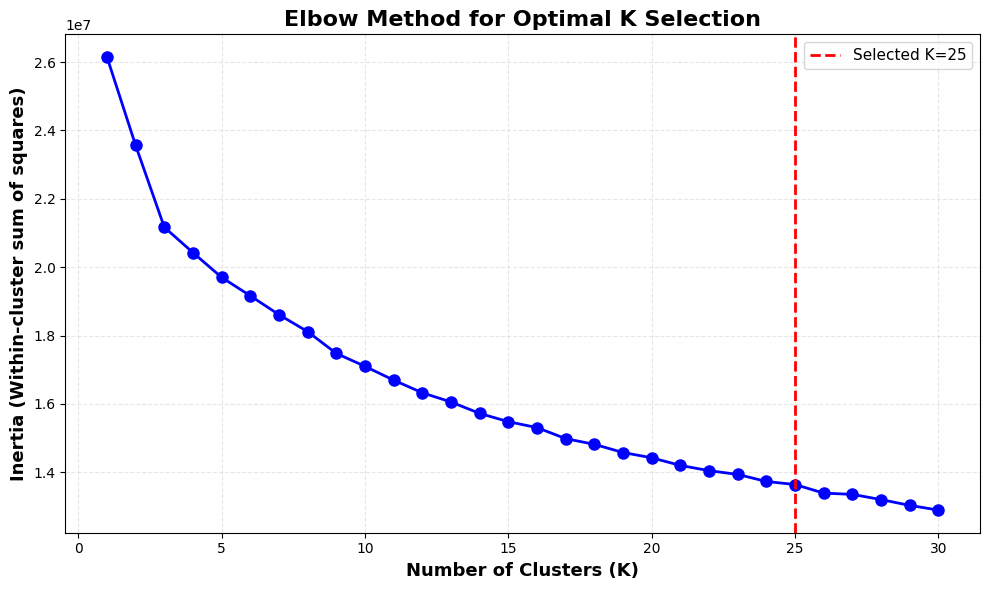

Elbow plot generated!


In [ ]:
print("Calculating Elbow Method...")
inertias = []
k_range = range(1, 31)

for k in k_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE, verbose=0)
    km.fit(X_train_pca)
    inertias.append(km.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.axvline(x=N_CLUSTERS, color='r', linestyle='--', linewidth=2,
            label=f'Selected K={N_CLUSTERS}')
plt.title('Elbow Method for Optimal K Selection', fontsize=16, fontweight='bold')
plt.xlabel('Number of Clusters (K)', fontsize=13, fontweight='bold')
plt.ylabel('Inertia (Within-cluster sum of squares)', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

print("Elbow plot generated!")